In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Graphics Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("🚀 INITIALIZING METHOD B: ADAPTIVE NEURO-FUZZY INFERENCE SYSTEM (ANFIS)")
print("Objective: Train a Neuro-Fuzzy network to learn optimal membership functions from data.")

🚀 INITIALIZING METHOD B: ADAPTIVE NEURO-FUZZY INFERENCE SYSTEM (ANFIS)
Objective: Train a Neuro-Fuzzy network to learn optimal membership functions from data.


In [2]:
# =============================================================================
# SECTION 1: DEFINING THE ANFIS NETWORK ARCHITECTURE (PYTORCH)
# This class implements a Sugeno-type Neuro-Fuzzy System using PyTorch.
# =============================================================================

class ANFIS_Network(nn.Module):
    def __init__(self, n_inputs, n_mfs):
        super(ANFIS_Network, self).__init__()
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs 
        self.n_rules = n_mfs ** n_inputs 
        
        # --- LAYER 1: FUZZIFICATION (Premise Parameters) ---
        # We use Gaussian Bell functions defined by Mean (mu) and Width (sigma).
        # These are the parameters the network will LEARN.
        self.mu = nn.Parameter(torch.randn(n_inputs, n_mfs)) 
        self.sigma = nn.Parameter(torch.ones(n_inputs, n_mfs)) # Sigma must be positive
        
        # --- LAYER 4: DEFUZZIFICATION (Consequent Parameters) ---
        # Sugeno output: y = ax1 + bx2 + ... + z
        # Weights for the linear equation of each rule.
        self.consequent_weights = nn.Parameter(torch.randn(self.n_rules, n_inputs + 1)) 

    def forward(self, x):
        batch_size = x.shape[0]
        
        # 1. Fuzzification (Gaussian MF)
        # Formula: exp(-0.5 * ((x - mu) / sigma)^2)
        x_expanded = x.unsqueeze(2).expand(-1, -1, self.n_mfs)
        mfs = torch.exp(-0.5 * ((x_expanded - self.mu) / self.sigma.abs()) ** 2)
        
        # 2. Rule Strength Calculation (Firing Strength)
        # We calculate the product of membership degrees for each rule.
        firing_strengths = mfs[:, 0, :] 
        for i in range(1, self.n_inputs):
            current_mfs = mfs[:, i, :]
            # Cartesian product of fuzzy sets to form rules
            firing_strengths = torch.bmm(firing_strengths.unsqueeze(2), current_mfs.unsqueeze(1)).view(batch_size, -1)
            
        # 3. Normalization (Firing Strength / Total Strength)
        total_strength = torch.sum(firing_strengths, dim=1, keepdim=True)
        normalized_strength = firing_strengths / (total_strength + 1e-6)
        
        # 4. Consequent Calculation (Linear Output)
        # Add bias term (1) to input x for linear equation y = wx + b
        x_with_bias = torch.cat([x, torch.ones(batch_size, 1).to(x.device)], dim=1)
        # Compute output for each rule
        rule_outputs = torch.matmul(x_with_bias, self.consequent_weights.t())
        
        # 5. Aggregation (Weighted Sum)
        final_output = torch.sum(normalized_strength * rule_outputs, dim=1)
        
        return final_output

print("✅ ANFIS Architecture Defined.")

✅ ANFIS Architecture Defined.


In [3]:
# =============================================================================
# SECTION 2: TRAINING & EVALUATION LOOP
# Train and test the model on both dataset iterations (50k samples each).
# =============================================================================

def train_and_evaluate_anfis(train_csv, test_csv, iteration_name):
    print(f"\n" + "="*60)
    print(f"🌀 PROCESSING {iteration_name}")
    print("="*60)
    
    if not os.path.exists(train_csv):
        print(f"❌ Error: Dataset '{train_csv}' not found. Please run 'anfis_data_creator.ipynb' first.")
        return None, None, None

    # 1. Data Loading
    print(f"   📂 Loading Data...")
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)
    
    # Convert to PyTorch Tensors
    X_train = torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32)
    y_train = torch.tensor(train_df.iloc[:, -1].values, dtype=torch.float32)
    
    X_test = torch.tensor(test_df.iloc[:, :-1].values, dtype=torch.float32)
    y_test = torch.tensor(test_df.iloc[:, -1].values, dtype=torch.float32)
    
    print(f"   Training Samples: {len(X_train)} | Test Samples: {len(X_test)}")

    # 2. Model Initialization
    # 7 Inputs, 2 Membership Functions per Input (Low, High) -> 2^7 = 128 Rules
    model = ANFIS_Network(n_inputs=7, n_mfs=2)
    
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.01) 
    
    # 3. Training Loop
    print("   ⚙️ Training Started...")
    epochs = 50 
    batch_size = 1024 
    loss_history = []
    
    model.train()
    for epoch in range(epochs):
        permutation = torch.randperm(X_train.size()[0])
        epoch_loss = 0
        
        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / (len(X_train)/batch_size)
        loss_history.append(avg_loss)
        
        if (epoch+1) % 10 == 0:
            print(f"      Epoch {epoch+1}/{epochs} - MSE Loss: {avg_loss:.4f}")

    # 4. Evaluation
    print("   🧪 Evaluating on Test Set...")
    model.eval()
    with torch.no_grad():
        test_preds_raw = model(X_test)
        # Round outputs to nearest integer (1-5)
        test_preds = torch.round(test_preds_raw).clamp(1, 5).numpy() 
        y_true = y_test.numpy()
        
    acc = accuracy_score(y_true, test_preds)
    print(f"   🏆 {iteration_name} Accuracy: %{acc*100:.2f}")

    # 5. Visualizations per Iteration
    
    # A) Loss Curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss', color='red')
    plt.title(f'Learning Curve ({iteration_name})')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # B) Confusion Matrix
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_true, test_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.title(f'Confusion Matrix ({iteration_name} acc: %{acc*100:.2f} )')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    return model, y_true, test_preds


🌀 PROCESSING Iteration 1
   📂 Loading Data...
   Training Samples: 37500 | Test Samples: 12500
   ⚙️ Training Started...
      Epoch 10/50 - MSE Loss: 0.1303
      Epoch 20/50 - MSE Loss: 0.0976
      Epoch 30/50 - MSE Loss: 0.0923
      Epoch 40/50 - MSE Loss: 0.0866
      Epoch 50/50 - MSE Loss: 0.0826
   🧪 Evaluating on Test Set...
   🏆 Iteration 1 Accuracy: %95.46


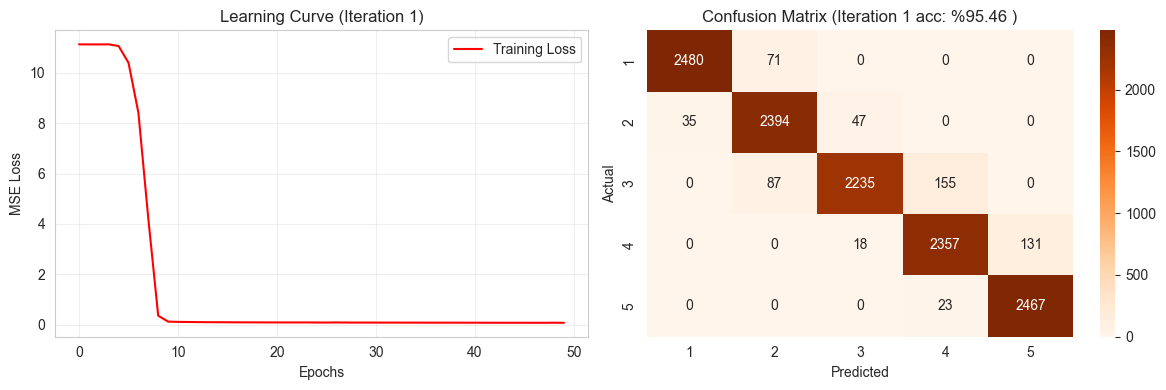


🌀 PROCESSING Iteration 2
   📂 Loading Data...
   Training Samples: 37500 | Test Samples: 12500
   ⚙️ Training Started...
      Epoch 10/50 - MSE Loss: 5.2854
      Epoch 20/50 - MSE Loss: 0.1138
      Epoch 30/50 - MSE Loss: 0.1073
      Epoch 40/50 - MSE Loss: 0.1023
      Epoch 50/50 - MSE Loss: 0.0994
   🧪 Evaluating on Test Set...
   🏆 Iteration 2 Accuracy: %92.82


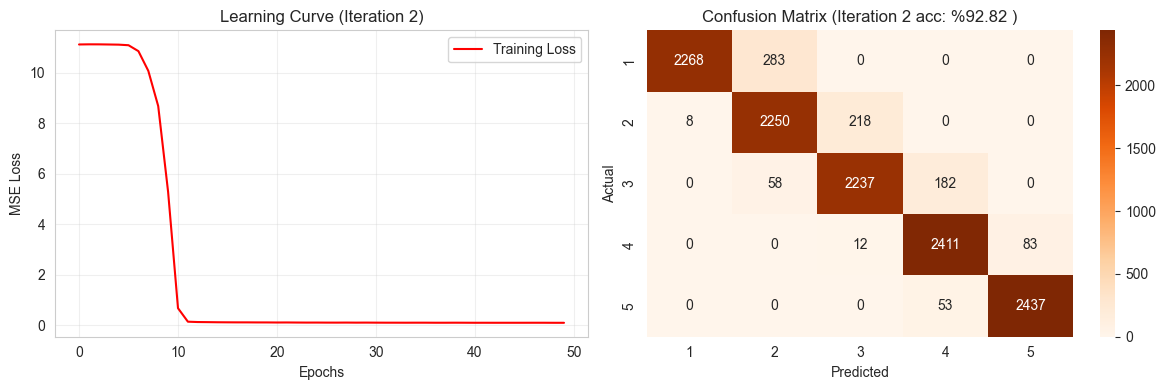

In [4]:
# --- RUN ITERATIONS ---

# Iteration 1
_, _, _ = train_and_evaluate_anfis('anfis_train_1.csv', 'anfis_test_1.csv', "Iteration 1")

# Iteration 2 (We keep the model for deep analysis)
trained_model, y_true_final, y_pred_final = train_and_evaluate_anfis('anfis_train_2.csv', 'anfis_test_2.csv', "Iteration 2")


🧠 DEEP DIVE ANALYSIS: WHAT DID THE MODEL LEARN?

1️⃣ Detailed Classification Report:
   Precision, Recall, and F1-Score for each class:
              precision    recall  f1-score   support

         1.0     0.9965    0.8891    0.9397      2551
         2.0     0.8684    0.9087    0.8881      2476
         3.0     0.9068    0.9031    0.9049      2477
         4.0     0.9112    0.9621    0.9359      2506
         5.0     0.9671    0.9787    0.9729      2490

    accuracy                         0.9282     12500
   macro avg     0.9300    0.9283    0.9283     12500
weighted avg     0.9304    0.9282    0.9284     12500


2️⃣ Learned Membership Functions (Gaussian Curves):
   The plots below show how the model adapted its definition of 'Low' and 'High'
   for the most critical features (e.g., Final Exam).


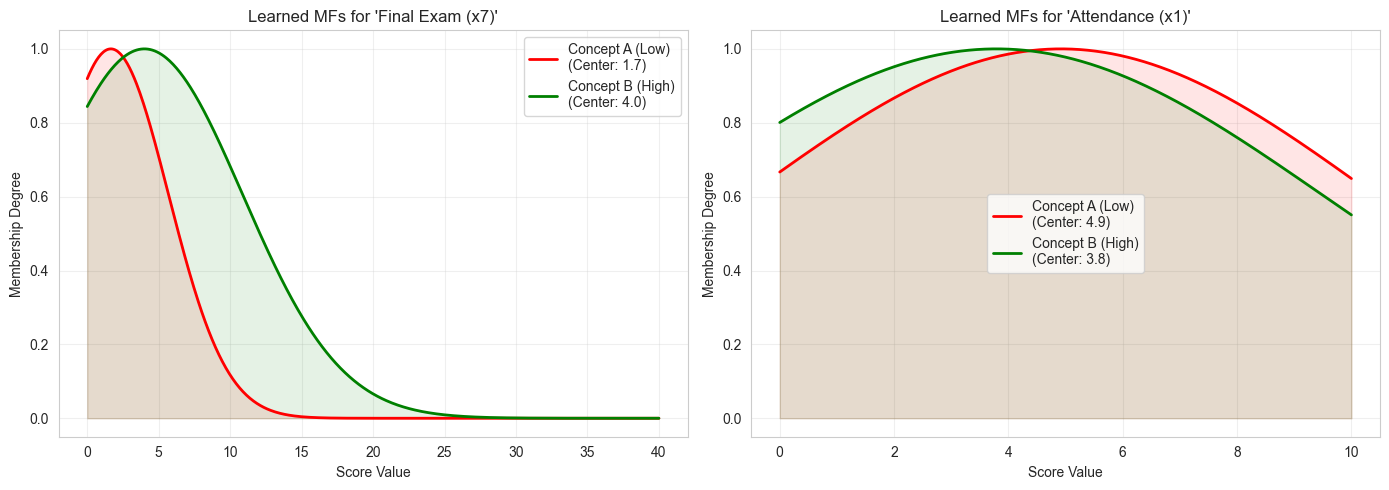

In [5]:
# =============================================================================
# SECTION 3: DEEP DIVE ANALYSIS (WHAT DID AI LEARN?)
# Visualizing the Classification Report and Learned Membership Functions.
# =============================================================================

def analyze_anfis_learning(model, y_true, y_pred):
    print("\n" + "="*60)
    print("🧠 DEEP DIVE ANALYSIS: WHAT DID THE MODEL LEARN?")
    print("="*60)
    
    # 1. Detailed Classification Metrics
    print("\n1️⃣ Detailed Classification Report:")
    print("   Precision, Recall, and F1-Score for each class:")
    print(classification_report(y_true, y_pred, digits=4))
    
    # 2. Visualizing Learned Parameters (Membership Functions)
    print("\n2️⃣ Learned Membership Functions (Gaussian Curves):")
    print("   The plots below show how the model adapted its definition of 'Low' and 'High'")
    print("   for the most critical features (e.g., Final Exam).")
    
    # Feature Index Mapping (0: Attendance ... 6: Final Exam)
    features_to_plot = {
        6: "Final Exam (x7)",
        0: "Attendance (x1)"
    }
    
    x_ranges = {
        6: np.linspace(0, 40, 500), # Final is 0-40
        0: np.linspace(0, 10, 500)  # Attendance is 0-10
    }

    plt.figure(figsize=(14, 5))
    
    for i, (idx, name) in enumerate(features_to_plot.items()):
        # Get parameters from GPU/CPU
        mu = model.mu.detach().cpu().numpy()[idx]
        sigma = model.sigma.detach().cpu().numpy()[idx]
        
        x_axis = x_ranges[idx]
        
        plt.subplot(1, 2, i+1)
        colors = ['red', 'green']
        labels = ['Concept A (Low)', 'Concept B (High)']
        
        for k in range(len(mu)):
            # Gaussian Formula
            y = np.exp(-0.5 * ((x_axis - mu[k]) / np.abs(sigma[k]))**2)
            plt.plot(x_axis, y, label=f'{labels[k]}\n(Center: {mu[k]:.1f})', color=colors[k], linewidth=2)
            plt.fill_between(x_axis, y, alpha=0.1, color=colors[k])
            
        plt.title(f"Learned MFs for '{name}'")
        plt.xlabel("Score Value")
        plt.ylabel("Membership Degree")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()
    
# Run Deep Analysis
if trained_model is not None:
    analyze_anfis_learning(trained_model, y_true_final, y_pred_final)